In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import yaml
from networkx.drawing.nx_agraph import graphviz_layout

In [5]:
network_log_env = pd.read_csv("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/output_20240702_204607/network_log.csv")
network_dt = network_log_env
with open("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/myparams/model_params.yaml", 'r') as stream:
    input_params = yaml.safe_load(stream)
agent_dt = pd.read_csv("/Users/ryaneng/Desktop/browncs/sph_lab/cadre/python/output_20240702_204607/agent_log.csv")

In [14]:
network_dt.head(10)

,tick,p1,p2
0,1,0,1330
1,1,0,3246
2,1,0,4452
3,1,0,5679
4,1,0,6265
5,1,0,9182
6,1,1,2677
7,1,1,3393
8,1,1,5179
9,1,1,5574


In [7]:
#processing final results from simulation
last_tick = network_dt["tick"].max()
last_tick_network_dt = network_dt[network_dt["tick"] == last_tick]
last_tick_agent_dt = agent_dt[agent_dt["tick"] == last_tick]

print(last_tick_network_dt)
print(last_tick_agent_dt)


           tick     p1     p2
21775483  10941      2   3518
21775484  10941      2   6999
21775485  10941      2  13000
21775486  10941      2  15102
21775487  10941      2  15373
...         ...    ...    ...
21795371  10941  15617  15618
21795372  10941  15617  15634
21795373  10941  15629  15635
21795374  10941  15631  15660
21795375  10941  15639  15641

[19893 rows x 3 columns]
           tick     id  age      race  female  alc_use_status smoking_status  \
10945700  10941   7418   84  Hispanic       1               0          Never   
10945701  10941   9735   84     Black       0               1          Never   
10945702  10941      2   71     White       1               0          Never   
10945703  10941      3   61  Hispanic       0               0          Never   
10945704  10941      4   53     White       1               0          Never   
...         ...    ...  ...       ...     ...             ...            ...   
10955697  10941  15697   72     Black       0         

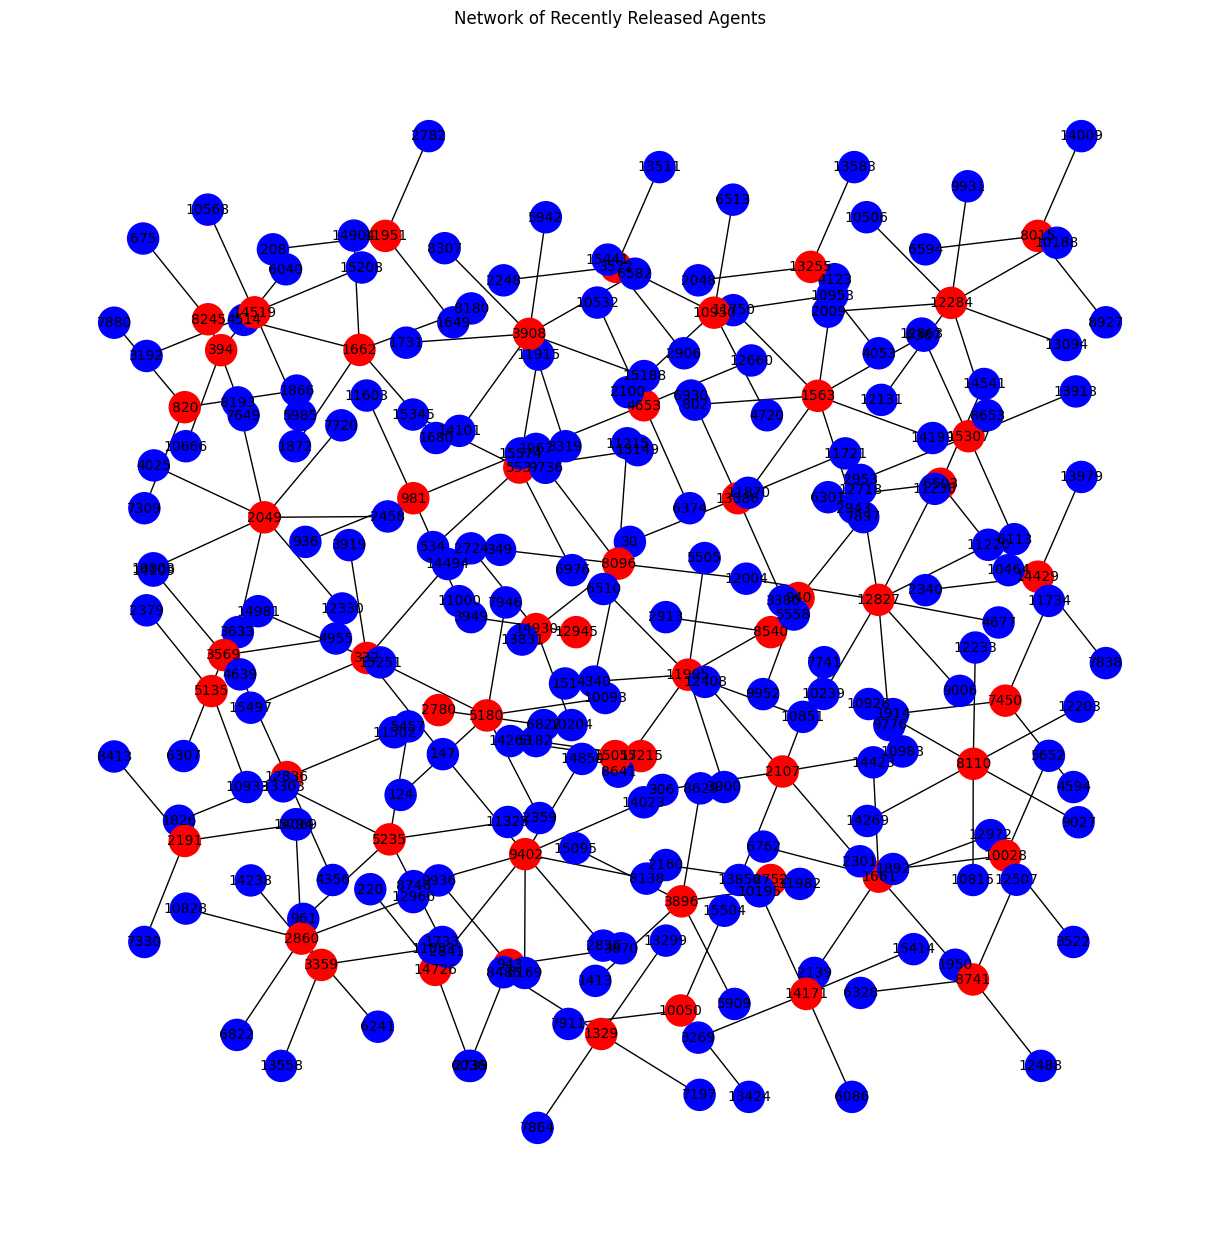

In [10]:
# Identify the IDs of the recently released agents
recently_released_agents = last_tick_agent_dt["id"][last_tick_agent_dt["last_release_tick"] > (last_tick - 365)]

# Get the network data for the recently released agents
network_recently_released = last_tick_network_dt[
    (last_tick_network_dt["p1"].isin(recently_released_agents)) |
    (last_tick_network_dt["p2"].isin(recently_released_agents))
]

# Get the first-degree network (neighbors) for each agent
first_degree_neighbors = pd.unique(network_recently_released[["p1", "p2"]].values.ravel('K'))

# Get agent data for the first-degree neighbors
first_degree_neighbors_agent_data = last_tick_agent_dt[last_tick_agent_dt["id"].isin(first_degree_neighbors)]

# Create an edge data frame from your network data
edf = pd.DataFrame({
    "from": network_recently_released["p1"],
    "to": network_recently_released["p2"]
})

# Create a node data frame with your agent data
ndf = pd.DataFrame({
    "id": first_degree_neighbors_agent_data["id"],
    "smoking_status": first_degree_neighbors_agent_data["smoking_status"],
    "alc_use_status": first_degree_neighbors_agent_data["alc_use_status"],
    "recently_released": ["Yes" if tick > (last_tick - 365) else "No" for tick in first_degree_neighbors_agent_data["last_release_tick"]]
})

# Create a NetworkX graph
G = nx.from_pandas_edgelist(edf, 'from', 'to')

# Add node attributes
for index, row in ndf.iterrows():
    G.nodes[row["id"]]["smoking_status"] = row["smoking_status"]
    G.nodes[row["id"]]["alc_use_status"] = row["alc_use_status"]
    G.nodes[row["id"]]["recently_released"] = row["recently_released"]

# Plot the network
plt.figure(figsize=(12, 12))
pos = graphviz_layout(G, prog="neato")
node_color = ["red" if G.nodes[node]["recently_released"] == "Yes" else "blue" for node in G.nodes]
nx.draw(G, pos, node_color=node_color, with_labels=True, node_size=500, font_size=10)
plt.title("Network of Recently Released Agents")
plt.show()